In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_folder = Path('../../data')
figure_folder = Path('../../Figures/')

In [3]:
intra_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4B_intracellular_conc_nmol_per_gprotein.csv'
extra_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4A_extracellular_conc_uM.csv'
live_dead_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4C_live_dead_results.csv'
od_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4D_sampling_OD.csv'

In [4]:
intra_df = pd.read_csv(intra_fn, index_col=0)
extra_df = pd.read_csv(extra_fn, index_col=0)
ld_df = pd.read_csv(live_dead_fn, index_col=0)

In [5]:
extra_df['Sample_id'] = extra_df['Sample_id'].str[:-7]

In [6]:
intra_df['Sample_id'] = intra_df['Sample_id'].str.replace('_', '-')

In [7]:
df_od = pd.read_csv(od_fn, index_col=0)

In [8]:
ld_df = ld_df.loc[ld_df.Dilution=='1X']

In [9]:
# Convert intracellular concentrations to total amount based on OD and conversion factors

# Get T4-T1 delta

In [10]:
extra_df_t1 = extra_df.loc[extra_df.Timepoint == 'T1']
extra_df_t4 = extra_df.loc[extra_df.Timepoint == 'T4']


In [11]:
metabolites = sorted(['Leucine',
       'Glutamate', 'Aspartate', 'Fructose-6-phosphate', 'Cis-aconitate'])
carbon_sources = ['Galactose', 'L-malate', 'L-alanine']

In [12]:
dfs = []
for m in metabolites:
    for cs in carbon_sources:
        t1_idx = (extra_df.Timepoint=='T1')&(extra_df['Carbon source']==cs)
        t4_idx = (extra_df.Timepoint=='T4')&(extra_df['Carbon source']==cs)
        t1_data = extra_df.loc[t1_idx, [m, 'Sample #']]
        t4_data = extra_df.loc[t4_idx, [m, 'Sample #']]

        # Discard data that has too few replicate values
        if t4_data[m].isna().sum() == len(t4_data):
            # All nan values at T4 - skip
            continue
        # elif t4_data[m].notna().sum()+t1_data[m].notna().sum()<3:
        #     continue
        
        # fill nan values in T1 data
        if t1_data[m].isna().sum() == len(t1_data):
            t1_data[m] = 0
        elif t1_data[m].isna().sum() > 0:
            t1_data[m].fillna(t1_data[m].mean())
            
        temp = pd.merge(left = t1_data, right=t4_data, left_on='Sample #', right_on='Sample #', suffixes=['-T1', '-T4'])
        temp['Δ concentration [uM]'] = temp[f'{m}-T4']-temp[f'{m}-T1']
        # temp['Carbon source'] = cs
        temp['Metabolite'] = m
        dfs.append(temp[['Sample #', 'Metabolite', 'Δ concentration [uM]']])#'Carbon source'


In [13]:
delta_ex = pd.concat(dfs)

In [14]:
delta_ex.loc[delta_ex['Δ concentration [uM]']<0, 'Δ concentration [uM]'] = np.nan

# Using OD as cell concentration measure

In [15]:
sample_id_to_od = df_od.set_index('Common sample ID')['OD at sampling'].to_dict()

In [16]:
intra_df['OD'] = intra_df.Sample_id.map(sample_id_to_od)


In [17]:
protein_density = 13.5*1e-8#  μg/μm^3 From Mori et al., 2017 (See SI) https://www.nature.com/articles/s41467-017-01242-8
# Protein density seems to be not correlated with growth rate

cubic_um_to_L = 1e-15 # L/um^3
protein_denisty_g_per_L = protein_density/cubic_um_to_L*1e-6

In [18]:
id_vars = ['Sample_id', 'Sample #', 'Carbon source', 'Timepoint', 'OD']
df_intraL = intra_df.melt(id_vars=id_vars, var_name='Metabolite', value_name='Concentration [nmol/g protein]')

In [19]:
df_intraL['Concentration [uM]'] = df_intraL['Concentration [nmol/g protein]']*protein_denisty_g_per_L*1e-3

In [20]:
total_cell_volume_per_od = 3.6 # uL per OD per mL Total cell volume conversion, see Volkmer and Heinemann 2011, https://pmc.ncbi.nlm.nih.gov/articles/PMC3146540/


In [21]:
# df_intraL['Corresponding E. concentration [mM]'] = df_intraL['Concentration [uM]']*total_cell_volume_per_od*df_intraL['OD']


In [22]:

df_intraL['Corresponding Ex. concentration [uM]'] = total_cell_volume_per_od*df_intraL['OD']*1e-6*df_intraL['Concentration [uM]']*1e3


In [23]:
df_death = df_intraL.merge(right=delta_ex, left_on=('Sample #', 'Metabolite'), right_on = ('Sample #', 'Metabolite'))

# Get dead fraction

In [24]:
ld_df['Sample #'] = ld_df.Sample_id.str[:2]

In [25]:
sample_to_dead_fraction = ld_df.loc[ld_df['Live/Dead']=='Live'].set_index('Sample #')['Dead fraction'].to_dict()

In [26]:
sample_to_dead_fraction

{'1A': 0.0022171887794224,
 '1B': 0.0236893152868333,
 '1C': 0.0023303582119796,
 '1D': 0.0031019757629409,
 '2A': 0.0075280044724333,
 '2B': 0.0076061408152461,
 '2C': 0.0067909055763592,
 '2D': 0.0059630171381029,
 '3A': 0.0022953767287055,
 '3B': 0.0020330137152567,
 '3C': 0.0037972866380275,
 '3D': 0.002241516749771}

In [27]:
df_death['Dead fraction'] = df_death['Sample #'].map(sample_to_dead_fraction)

In [ ]:
df_death['Fraction explained'] = df_death['Corresponding Ex. concentration [uM]']*df_death['Dead fraction']/df_death['Δ concentration [uM]']

In [45]:
df_death.dropna(subset=['Fraction explained'], inplace=True)

In [155]:
df_death['Δ concentration [uM]']

26    0.071309
28    2.025250
29    2.113758
30    3.884124
31    4.306714
44    0.760151
45    0.745879
46    0.768665
47    0.800146
53    1.776131
54    1.742494
55    1.609172
48    0.683595
49    0.692965
50    0.918602
51    0.970204
41    0.830740
42    0.737945
36    0.292968
37    0.303776
38    0.201566
12    3.556297
13    3.565419
14    3.507794
15    3.570236
21    0.986385
22    1.290596
23    1.113683
0     0.098883
1     0.093184
2     0.119344
3     0.119280
9     0.633571
10    0.696213
11    0.748305
6     0.000393
7     0.000450
Name: Δ concentration [uM], dtype: float64

i: 0, m: Aspartate, cs: Galactose, sizes: [33.53144346], [25]
i: 2, m: Aspartate, cs: L-malate, sizes: [48.06478641 48.25055264 50.89293086 51.34146032], [25]
i: 3, m: Cis-aconitate, cs: Galactose, sizes: [43.80899871 43.7266838  43.85737107 44.03169239], [25]
i: 4, m: Cis-aconitate, cs: L-alanine, sizes: [47.49474994 47.41171291 47.06602467], [25]
i: 5, m: Cis-aconitate, cs: L-malate, sizes: [43.34798878 43.407113   44.63127387 44.86863061], [25]
i: 7, m: Fructose-6-phosphate, cs: L-alanine, sizes: [44.19465122 43.68023994], [25]
i: 8, m: Fructose-6-phosphate, cs: L-malate, sizes: [39.66820186 39.82553459 38.04417277], [25]
i: 9, m: Glutamate, cs: Galactose, sizes: [50.50998023 50.52110574 50.45034081 50.52696925], [25]
i: 10, m: Glutamate, cs: L-alanine, sizes: [44.94046459 46.10790315 45.4676159 ], [25]
i: 12, m: Leucine, cs: Galactose, sizes: [34.95121634 34.69341349 35.7680059  35.7656763 ], [25]
i: 13, m: Leucine, cs: L-alanine, sizes: [43.0179529  43.42742128 43.74078647], [25]


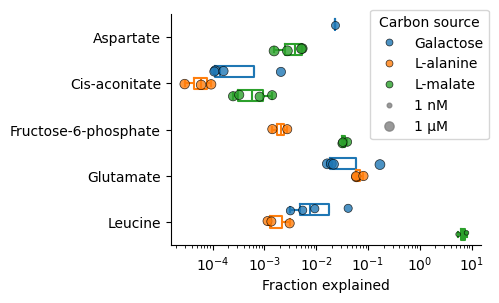

In [244]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, figsize = (4,3))
# Normalize the size column to control the point size
df_death['log10(Δ concentration [uM])'] = np.log10(df_death['Δ concentration [uM]'])
df_death.sort_values(by = ['Metabolite', 'Carbon source'], inplace=True)    
size_column = 'log10(Δ concentration [uM])' # Replace with the column name in your DataFrame
sizes = ((df_death[size_column] + 4) *10) + 5
df_death['Size'] = sizes


# Define the order explicitly for Metabolite and Carbon source
metabolite_order = sorted(df_death['Metabolite'].unique())
carbon_source_order = sorted(df_death['Carbon source'].unique())


l = sns.boxplot(df_death, x = 'Fraction explained', hue = 'Carbon source', y = 'Metabolite', fill = False,gap=.1,
                ax = ax, legend = None, fliersize = 0,
                order = metabolite_order, hue_order = carbon_source_order)
                # order = sorted(df_death.Metabolite.unique()))#color = 'w', , linecolor = 'grey'

strip = sns.stripplot(df_death, x = 'Fraction explained', hue = 'Carbon source', y = 'Metabolite', dodge=True, ax = ax,
             edgecolor = 'k', linewidth = 0.5, alpha = 0.8,
             order= metabolite_order, hue_order = carbon_source_order,
            #  s = sizes.values
)
# Map each artist to its corresponding group
# Iterate over the collections and match them to the grouped data
i = 0
group_data = df_death.groupby(['Metabolite', 'Carbon source'], sort=False)
for m in metabolite_order:
    for cs in carbon_source_order:
        artist = strip.collections[i]
        try:
            sizes = group_data.get_group((m, cs))['Size'].values
        except KeyError:
            i += 1
            continue
        
        print(f"i: {i}, m: {m}, cs: {cs}, sizes: {sizes}, {artist.get_sizes()}")
        artist.set_sizes(sizes)
        i += 1


size_legend_labels = ['1 nM', '1 μM']  # Example labels for the legend
legend_values = [-3, -2, -1, 0]  # Example values to display in the legend
size_legend_size = [((x + 4)*10) for x in legend_values]
# size_legend_values = [-3, -2, 10]  # Example sizes to display in the legend
# size_legend_labels = [f"{10**((size - 10) / 50 * (df_death[size_column].max() - df_death[size_column].min()) + df_death[size_column].min()):.2f}" for size in size_legend_values]

# Create circular markers for the size legend
size_handles = [
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=size/3, label=label, alpha=0.8)
    for size, label in zip(size_legend_size, size_legend_labels)
]


# Get the existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Combine the existing legend with the size legend
combined_handles = handles + size_handles
combined_labels = labels + size_legend_labels

# Add the combined legend to the plot
ax.legend(
    combined_handles,
    combined_labels,
    title='Carbon source',
    loc="upper right",
    bbox_to_anchor=(1.05, 1.05),
    # ha = 'right',
    frameon=True
)
ax.set_xscale('log')
ax.set_ylabel('')
sns.despine()
fig_fn = figure_folder / '2_paired_death_1.pdf'
plt.savefig(fig_fn, bbox_inches='tight')

In [179]:
size_legend_size

[15.020200507996517, 27.39719336807137, 39.77418622814623, 52.15117908822108]

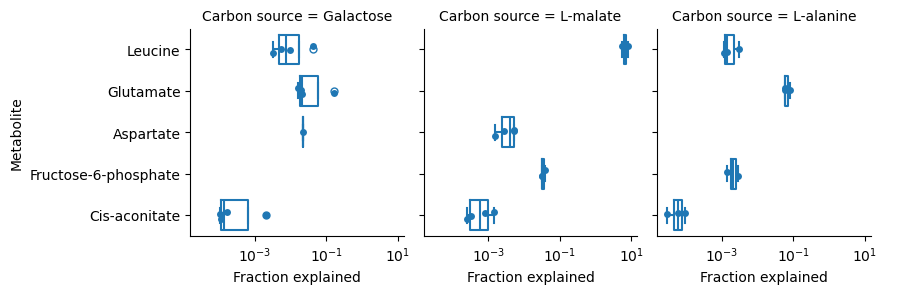

In [30]:
g = sns.catplot(df_death, x = 'Fraction explained', col = 'Carbon source', y = 'Metabolite', fill = False,gap=.1, kind ='box', height=3)
g.map_dataframe(sns.stripplot, data = df_death, x = 'Fraction explained', y = 'Metabolite', dodge=True)
for ax in g.axes[0]:
    ax.set_xscale('log')
sns.despine()
fig_fn = figure_folder / '2_paired_death_3.pdf'
plt.savefig(fig_fn)

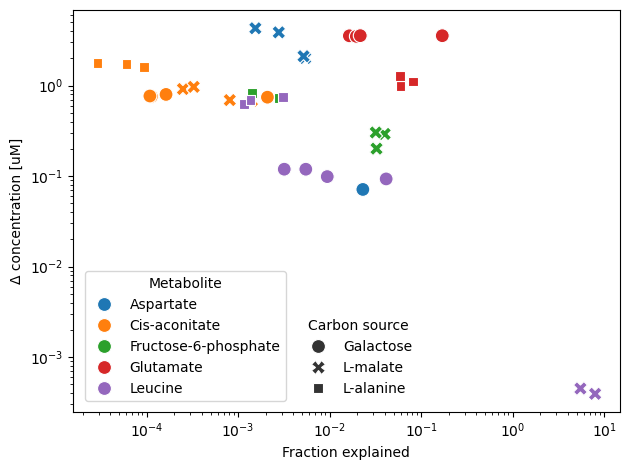

In [242]:
import matplotlib.pyplot as plt

# Create the scatterplot
ax = sns.scatterplot(
    data=df_death,
    x='Fraction explained',
    y='Δ concentration [uM]',
    hue='Metabolite',
    style='Carbon source',
    s=100
)

# Get the handles and labels for hue and style
hue_handles, hue_labels = ax.get_legend_handles_labels()
style_handles = [h for h, l in zip(hue_handles, hue_labels) if l in df_death['Carbon source'].unique()]
hue_handles = [h for h, l in zip(hue_handles, hue_labels) if l in df_death['Metabolite'].unique()]

# Create separate legends for hue and style
hue_legend = ax.legend(
    handles=hue_handles,
    labels=[x for x in df_death['Metabolite'].unique()],
    title="Metabolite",
    loc="lower left",
    bbox_to_anchor=(0.01, 0.01),
    frameon=True
)

style_legend = ax.legend(
    handles=style_handles,
    labels=[x for x in df_death['Carbon source'].unique()],
    title="Carbon source",
    loc="lower left",
    bbox_to_anchor=(0.4, 0.01),
    frameon=False
)

# Add the legends to the plot
ax.add_artist(hue_legend)

# Set log scales
ax.set_yscale('log')
ax.set_xscale('log')

plt.tight_layout()
plt.show()

# Fraction explained if all cells are lysed

In [32]:
df_death['Fraction explained all cells lysed'] = df_death['Corresponding Ex. concentration [uM]']/df_death['Δ concentration [uM]']

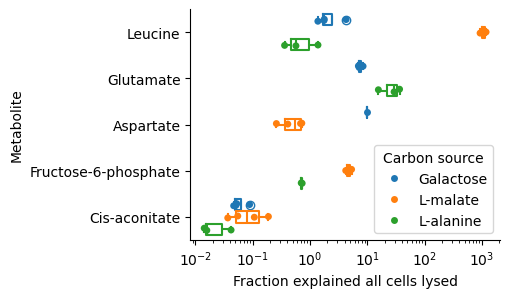

In [33]:
fig, ax = plt.subplots(1, figsize = (4,3))
l = sns.boxplot(df_death, x = 'Fraction explained all cells lysed', hue = 'Carbon source', y = 'Metabolite', fill = False,gap=.1,
                ax = ax, legend = None)
sns.stripplot(df_death, x = 'Fraction explained all cells lysed', hue = 'Carbon source', y = 'Metabolite', dodge=True, ax = ax)
ax.set_xscale('log')
sns.despine()
